In [ ]:
pip install torch torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 85.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 76.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 116.9 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torchvision.models import alexnet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128,
                                           shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                          shuffle=False, num_workers=2)
model = alexnet(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
model.classifier[6] = nn.Linear(4096, 10)
for param in model.classifier[6].parameters():
    param.requires_grad = True
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier[6].parameters(), lr=0.001)
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/5], Loss: {running_loss / len(train_loader):.4f}")
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy after 5 epochs : {100 * correct / total:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 0.8894
Epoch [2/5], Loss: 0.7610
Epoch [3/5], Loss: 0.7425
Epoch [4/5], Loss: 0.7230
Epoch [5/5], Loss: 0.7134
Test Accuracy after 5 epochs : 78.39%


Classification Report:

              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.86      0.82      0.84      1000
        bird       0.76      0.72      0.74      1000
         cat       0.64      0.70      0.67      1000
        deer       0.73      0.75      0.74      1000
         dog       0.84      0.64      0.72      1000
        frog       0.82      0.80      0.81      1000
       horse       0.74      0.86      0.80      1000
        ship       0.90      0.81      0.85      1000
       truck       0.79      0.90      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



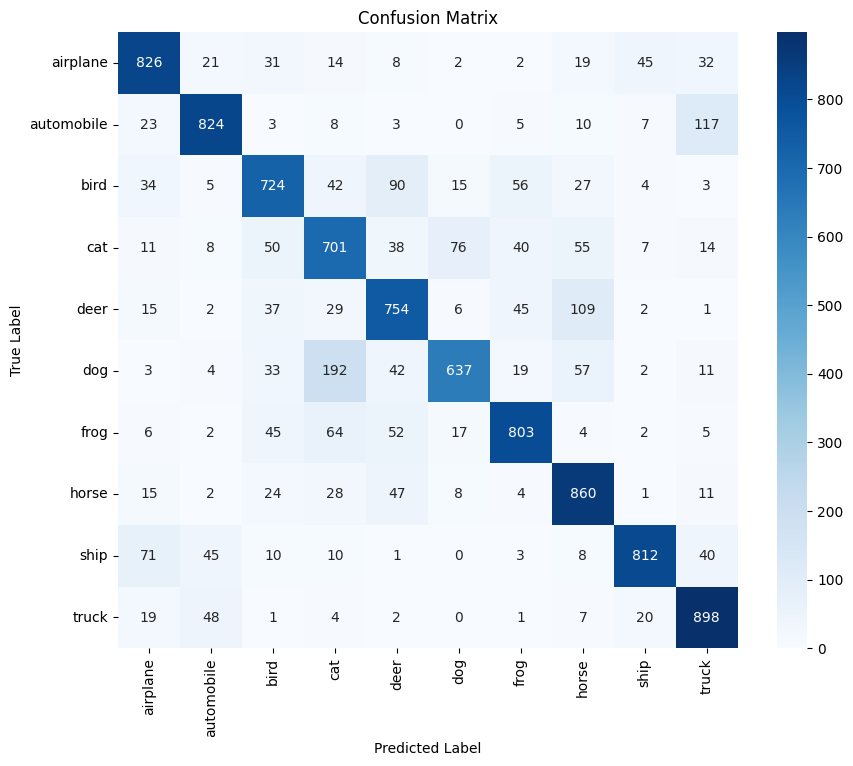

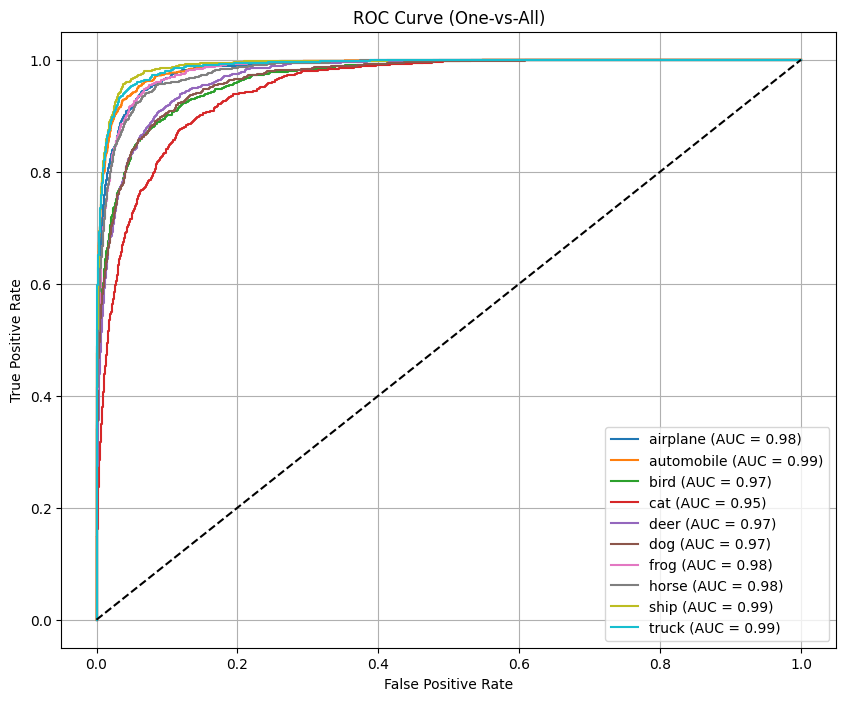

In [15]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(10)))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (One-vs-All)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                             transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64,
                                           shuffle=True, num_workers=2)

test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                            transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=100,
                                          shuffle=False, num_workers=2)


In [14]:
model_vgg16 = vgg16(pretrained=True)
for param in model_vgg16.parameters():
    param.requires_grad = False
model_vgg16.classifier[6] = nn.Linear(4096, 10)
for param in model_vgg16.classifier[6].parameters():
    param.requires_grad = True
model_vgg16 = model_vgg16.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg16.classifier[6].parameters(), lr=0.001)
for epoch in range(5):
    model_vgg16.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_vgg16(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[VGG16] Epoch {epoch+1}/5, Loss: {running_loss / len(train_loader):.4f}")
model_vgg16.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg16(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
print(f"[VGG16] Test Accuracy: {100 * correct / total:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


[VGG16] Epoch 1/5, Loss: 0.7847
[VGG16] Epoch 2/5, Loss: 0.7104
[VGG16] Epoch 3/5, Loss: 0.6989
[VGG16] Epoch 4/5, Loss: 0.6998
[VGG16] Epoch 5/5, Loss: 0.6971
[VGG16] Test Accuracy: 80.28%


Classification Report:

              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.86      0.82      0.84      1000
        bird       0.76      0.72      0.74      1000
         cat       0.64      0.70      0.67      1000
        deer       0.73      0.75      0.74      1000
         dog       0.84      0.64      0.72      1000
        frog       0.82      0.80      0.81      1000
       horse       0.74      0.86      0.80      1000
        ship       0.90      0.81      0.85      1000
       truck       0.79      0.90      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



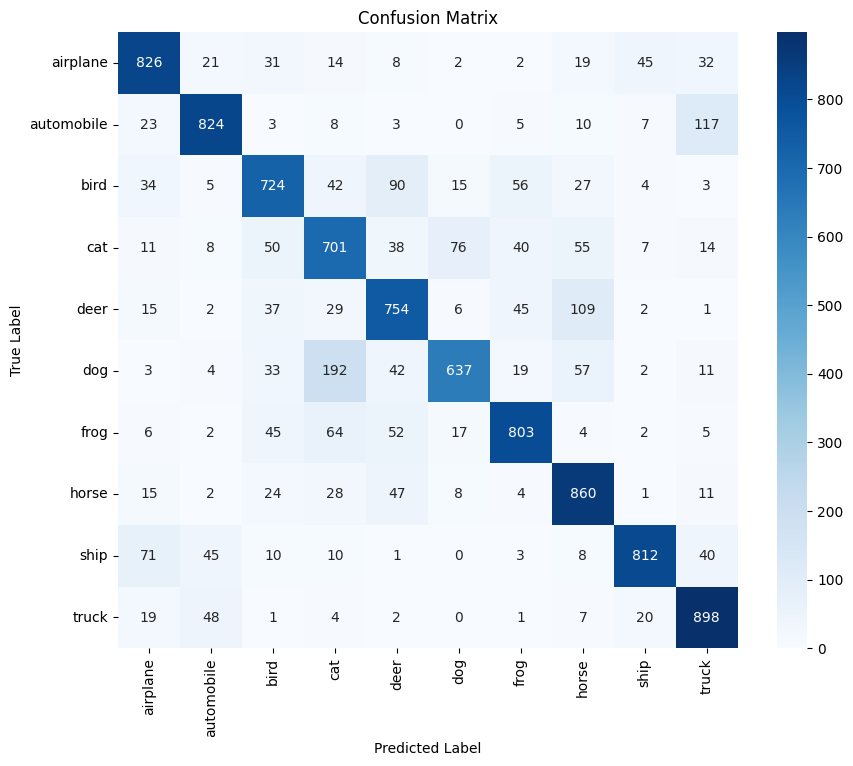

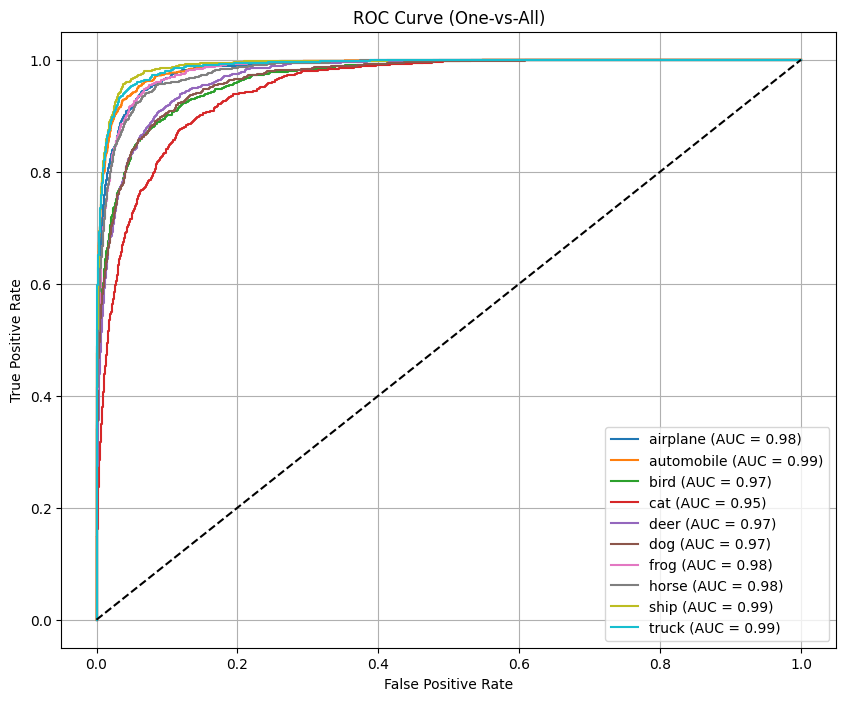

In [16]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(10)))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (One-vs-All)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


In [4]:
model_vgg19 = vgg19(pretrained=True)
for param in model_vgg19.parameters():
    param.requires_grad = False
model_vgg19.classifier[6] = nn.Linear(4096, 10)
for param in model_vgg19.classifier[6].parameters():
    param.requires_grad = True
model_vgg19 = model_vgg19.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_vgg19.classifier[6].parameters(), lr=0.001)
for epoch in range(5):
    model_vgg19.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_vgg19(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"[VGG19] Epoch {epoch+1}/5, Loss: {running_loss / len(train_loader):.4f}")
model_vgg19.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_vgg19(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"[VGG19] Test Accuracy: {100 * correct / total:.2f}%")


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth
100%|██████████| 548M/548M [00:05<00:00, 100MB/s] 


[VGG19] Epoch 1/5, Loss: 0.7667
[VGG19] Epoch 2/5, Loss: 0.7046
[VGG19] Epoch 3/5, Loss: 0.6881
[VGG19] Epoch 4/5, Loss: 0.6899
[VGG19] Epoch 5/5, Loss: 0.6886
[VGG19] Test Accuracy: 79.17%


📊 Classification Report:

              precision    recall  f1-score   support

    airplane       0.81      0.83      0.82      1000
  automobile       0.86      0.82      0.84      1000
        bird       0.76      0.72      0.74      1000
         cat       0.64      0.70      0.67      1000
        deer       0.73      0.75      0.74      1000
         dog       0.84      0.64      0.72      1000
        frog       0.82      0.80      0.81      1000
       horse       0.74      0.86      0.80      1000
        ship       0.90      0.81      0.85      1000
       truck       0.79      0.90      0.84      1000

    accuracy                           0.78     10000
   macro avg       0.79      0.78      0.78     10000
weighted avg       0.79      0.78      0.78     10000



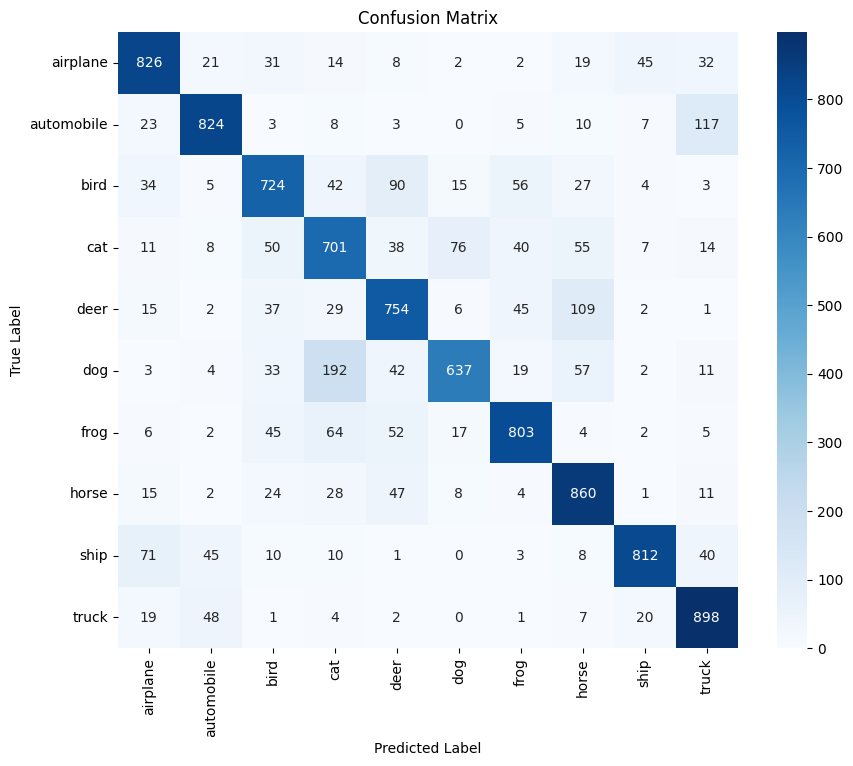

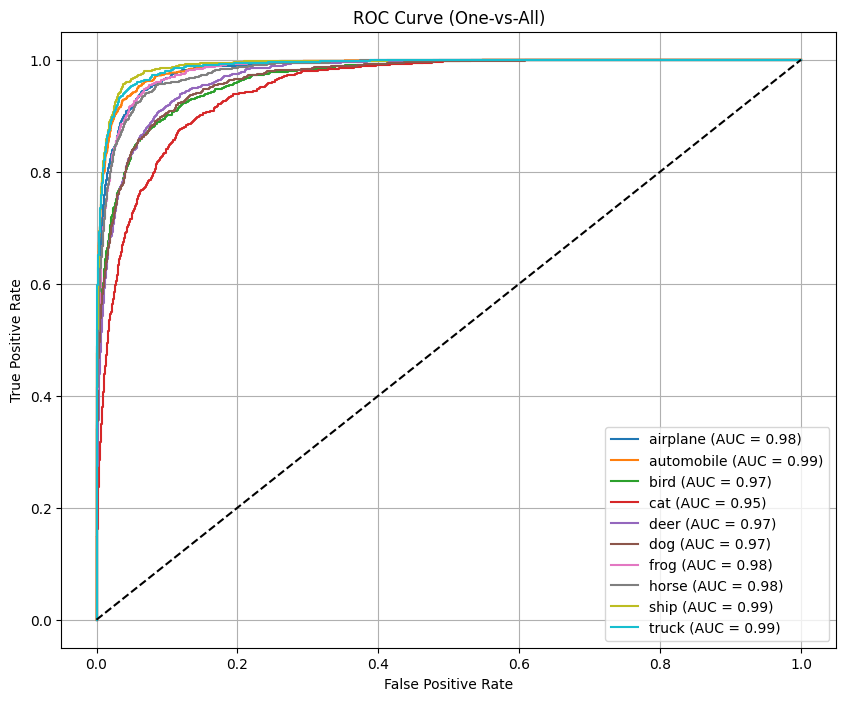

In [13]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize

class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']


y_true = []
y_pred = []
y_probs = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        probs = torch.softmax(outputs, dim=1)

        _, predicted = torch.max(probs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())
y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_probs = np.array(y_probs)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

y_true_bin = label_binarize(y_true, classes=list(range(10)))

fpr = dict()
tpr = dict()
roc_auc = dict()

plt.figure(figsize=(10, 8))
for i in range(10):
    fpr[i], tpr[i], _ = roc_curve(y_true_bin[:, i], y_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f"{class_names[i]} (AUC = {roc_auc[i]:.2f})")

# Plot diagonal line
plt.plot([0, 1], [0, 1], 'k--')
plt.title("ROC Curve (One-vs-All)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()
